In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
    roc_auc_score, average_precision_score, brier_score_loss, fbeta_score, \
    confusion_matrix, classification_report, roc_curve, precision_recall_curve, \
    average_precision_score, auc
import matplotlib.pyplot as plt
pd.options.display.max_rows = 400
pd.options.display.max_columns = 400
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import lightgbm as lgb

In [11]:
import time
from scipy.stats import randint as sp_randint

In [12]:
df = pd.read_csv('regdata_train.csv').sort_values(by='MemberID')\
    .reset_index().drop(['index'],axis=1)
df_test = pd.read_csv('regdata_test.csv').sort_values(by='MemberID')\
    .reset_index().drop(['index'],axis=1)

In [13]:
df.head(1)

,y_hfadmit,MemberID,y_hfadmit_q1,y_hfadmit_q2,y_hfadmit_q3,y_hfadmit_q4,Gender,age,agcode,agcode2,MR_Allowed,mr_allowed_q1,mr_allowed_q2,mr_allowed_q3,mr_allowed_q4,rs15_comna,grvu,grvu_q1,grvu_q2,grvu_q3,grvu_q4,ER_visits,grvu_ER,ER_visits_q3,ER_visits_q1,ER_visits_q2,ER_visits_q4,grvu_ER_q3,grvu_ER_q1,grvu_ER_q2,grvu_ER_q4,PCP_visits,grvu_PCP,PCP_visits_q3,PCP_visits_q4,PCP_visits_q1,PCP_visits_q2,grvu_PCP_q3,grvu_PCP_q4,grvu_PCP_q1,grvu_PCP_q2,Spec_visits,grvu_Spec,Spec_visits_q1,Spec_visits_q2,Spec_visits_q3,Spec_visits_q4,grvu_Spec_q1,grvu_Spec_q2,grvu_Spec_q3,grvu_Spec_q4,UC_visits,grvu_UC,UC_visits_q1,UC_visits_q2,UC_visits_q3,UC_visits_q4,grvu_UC_q1,grvu_UC_q2,grvu_UC_q3,grvu_UC_q4,OP_visits,grvu_OP,OP_visits_q1,OP_visits_q2,OP_visits_q3,OP_visits_q4,grvu_OP_q1,grvu_OP_q2,grvu_OP_q3,grvu_OP_q4,admits,days_admits,grvu_admits,admits_q1,admits_q4,admits_q2,admits_q3,days_admits_q1,days_admits_q4,days_admits_q2,days_admits_q3,grvu_admits_q1,grvu_admits_q4,grvu_admits_q2,grvu_admits_q3,hfadmits,days_hfadmits,grvu_hfadmits,hfadmits_q3,hfadmits_q1,hfadmits_q4,hfadmits_q2,days_hfadmits_q3,days_hfadmits_q1,days_hfadmits_q4,days_hfadmits_q2,grvu_hfadmits_q3,grvu_hfadmits_q1,grvu_hfadmits_q4,grvu_hfadmits_q2,GPI4_0120,GPI4_0340,GPI4_1710,GPI4_1899,GPI4_2210,GPI4_2400,GPI4_4420,GPI4_5710,GPI4_5816,GPI4_6510,GPI4_6599,GPI4_6610,GPI4_7260,GPI4_7510,GPI4_0500,GPI4_2725,GPI4_3320,GPI4_3620,GPI4_3720,GPI4_3940,GPI4_5685,GPI4_6020,GPI4_6800,GPI4_7970,GPI4_8610,GPI4_8630,GPI4_8680,GPI4_9015,GPI4_9410,GPI4_9720,GPI4_2720,GPI4_3330,GPI4_3699,GPI4_4220,GPI4_0210,GPI4_1140,GPI4_1622,GPI4_2810,GPI4_3750,GPI4_4920,GPI4_4927,GPI4_7210,GPI4_9055,GPI4_0199,GPI4_1250,GPI4_1600,GPI4_3400,GPI4_3615,GPI4_4450,GPI4_8210,GPI4_8310,GPI4_8320,GPI4_0230,GPI4_1699,GPI4_2710,GPI4_3210,GPI4_3945,GPI4_5820,GPI4_8337,GPI4_9705,GPI4_0400,GPI4_3530,GPI4_4930,GPI4_3310,GPI4_3540,GPI4_3760,GPI4_3610,GPI4_4410,GPI4_4440,GPI4_3090,GPI4_3120,GPI4_4699,GPI4_9010,GPI4_5300,GPI4_5812,GPI4_5818,GPI4_7320,GPI4_1720,GPI4_4014,GPI4_4660,GPI4_5830,GPI4_8333,GPI4_4240,GPI4_5803,GPI4_2760,GPI4_5025,GPI4_5230,GPI4_8810,GPI4_9085,GPI4_0220,GPI4_8515,GPI4_2310,GPI4_2140,GPI4_6499,GPI4_8672,GPI4_8815,GPI4_1240,GPI4_3890,GPI4_5410,...,GPI4_6250,GPI4_3040,GPI4_7831,GPI4_3045,GPI4_2515,GPI4_9539,GPI4_4899,GPI4_7821,GPI4_8125,GPI4_5028,GPI4_3020,GPI4_4340,GPI4_8665,GPI4_2175,GPI4_3017,GPI4_4460,GPI4_6280,GPI4_7340,GPI4_9420,GPI4_6627,GPI4_4510,GPI4_6999,GPI4_9340,GPI4_3030,GPI4_9680,GPI4_4799,GPI4_7580,GPI4_7905,GPI4_1610,GPI4_0250,GPI4_2137,GPI4_6640,GPI4_6760,GPI4_2597,GPI4_6135,GPI4_7813,GPI4_6200,GPI4_8050,GPI4_7450,GPI4_6254,GPI4_9920,GPI4_9080,GPI4_9730,GPI4_9630,GPI4_9066,GPI4_3010,GPI4_7844,GPI4_1399,GPI4_9220,GPI4_9620,GPI4_9648,GPI4_9666,GPI4_9676,GPI4_9836,GPI4_2599,GPI4_4415,GPI4_5216,GPI4_9007,GPI4_6799,GPI4_9682,GPI4_5540,GPI4_9652,GPI4_9737,GPI4_9075,GPI4_9503,GPI4_9518,GPI4_9599,GPI4_6030,GPI4_1150,GPI4_2715,GPI4_7240,GPI4_9664,GPI4_6245,GPI4_8845,GPI4_6238,GPI4_9073,GPI4_6650,GPI4_9656,GPI4_9087,GPI4_1910,GPI4_6625,GPI4_2510,GPI4_9642,GPI4_9668,GPI4_2135,GPI4_9052,GPI4_7212,GPI4_2150,GPI4_5610,GPI4_2199,GPI4_2757,GPI4_9935,GPI4_0800,GPI4_8830,GPI4_7835,GPI4_8280,GPI4_8925,GPI4_9672,GPI4_6120,GPI4_4110,GPI4_3630,GPI4_7812,GPI4_2120,GPI4_7850,GPI4_3948,GPI4_6222,GPI4_4725,GPI4_5253,GPI4_7843,GPI4_9300,GPI4_2320,GPI4_6220,GPI4_8250,GPI4_3018,GPI4_9430,GPI4_8940,GPI4_6125,GPI4_6626,GPI4_3870,HCC1,HCC2,HCC6,HCC8,HCC9,HCC10,HCC11,HCC12,HCC17,HCC18,HCC19,HCC21,HCC22,HCC23,HCC27,HCC28,HCC29,HCC33,HCC34,HCC35,HCC39,HCC40,HCC46,HCC47,HCC48,HCC54,HCC55,HCC57,HCC58,HCC70,HCC71,HCC72,HCC73,HCC74,HCC75,HCC76,HCC77,HCC78,HCC79,HCC80,HCC82,HCC83,HCC84,HCC85,HCC86,HCC87,HCC88,HCC96,HCC99,HCC100,HCC103,HCC104,HCC106,HCC107,HCC108,HCC110,HCC111,HCC112,HCC114,HCC115,HCC122,HCC124,HCC134,HCC135,HCC136,HCC137,HCC157,HCC158,HCC161,HCC162,HCC166,HCC167,HCC169,HCC170,HCC173,HCC176,HCC186,HCC188,HCC189,SelectionProb,SamplingWeight
0,0,002A4ZJSB78GA4SVCM5,0,0,0,0,F,55,F64_LE,F64_LE,39949.08,293

In [14]:
var_list = [
    'y_hfadmit',
    'Gender',
    'age',
    'rs15_comna',
    'mr_allowed_q1','mr_allowed_q2','mr_allowed_q3','mr_allowed_q4',
    'ER_visits_q1','ER_visits_q2','ER_visits_q3','ER_visits_q4', 
    'PCP_visits_q1','PCP_visits_q2','PCP_visits_q3','PCP_visits_q4',
    'Spec_visits_q1','Spec_visits_q2','Spec_visits_q3','Spec_visits_q4', 
    'UC_visits_q1','UC_visits_q2','UC_visits_q3','UC_visits_q4',
    'OP_visits_q1','OP_visits_q2','OP_visits_q3','OP_visits_q4',
    'admits_q1','admits_q2','admits_q3','admits_q4',
    'hfadmits_q1','hfadmits_q2','hfadmits_q3','hfadmits_q4',
    'days_admits_q1','days_admits_q2','days_admits_q3','days_admits_q4',
    'days_hfadmits_q1','days_hfadmits_q2','days_hfadmits_q3','days_hfadmits_q4'
]
for lab in df.columns: 
    if 'GPI4_' in lab:
        var_list.append(lab)
for lab in df.columns: 
    if 'HCC' in lab:
        var_list.append(lab)


In [15]:
df.reg = df.loc[:,var_list]
df_test.reg = df_test.loc[:,var_list]

In [16]:
df.reg.head(10)

,y_hfadmit,Gender,age,rs15_comna,mr_allowed_q1,mr_allowed_q2,mr_allowed_q3,mr_allowed_q4,ER_visits_q1,ER_visits_q2,ER_visits_q3,ER_visits_q4,PCP_visits_q1,PCP_visits_q2,PCP_visits_q3,PCP_visits_q4,Spec_visits_q1,Spec_visits_q2,Spec_visits_q3,Spec_visits_q4,UC_visits_q1,UC_visits_q2,UC_visits_q3,UC_visits_q4,OP_visits_q1,OP_visits_q2,OP_visits_q3,OP_visits_q4,admits_q1,admits_q2,admits_q3,admits_q4,hfadmits_q1,hfadmits_q2,hfadmits_q3,hfadmits_q4,days_admits_q1,days_admits_q2,days_admits_q3,days_admits_q4,days_hfadmits_q1,days_hfadmits_q2,days_hfadmits_q3,days_hfadmits_q4,GPI4_0120,GPI4_0340,GPI4_1710,GPI4_1899,GPI4_2210,GPI4_2400,GPI4_4420,GPI4_5710,GPI4_5816,GPI4_6510,GPI4_6599,GPI4_6610,GPI4_7260,GPI4_7510,GPI4_0500,GPI4_2725,GPI4_3320,GPI4_3620,GPI4_3720,GPI4_3940,GPI4_5685,GPI4_6020,GPI4_6800,GPI4_7970,GPI4_8610,GPI4_8630,GPI4_8680,GPI4_9015,GPI4_9410,GPI4_9720,GPI4_2720,GPI4_3330,GPI4_3699,GPI4_4220,GPI4_0210,GPI4_1140,GPI4_1622,GPI4_2810,GPI4_3750,GPI4_4920,GPI4_4927,GPI4_7210,GPI4_9055,GPI4_0199,GPI4_1250,GPI4_1600,GPI4_3400,GPI4_3615,GPI4_4450,GPI4_8210,GPI4_8310,GPI4_8320,GPI4_0230,GPI4_1699,GPI4_2710,GPI4_3210,GPI4_3945,GPI4_5820,GPI4_8337,GPI4_9705,GPI4_0400,GPI4_3530,GPI4_4930,GPI4_3310,GPI4_3540,GPI4_3760,GPI4_3610,GPI4_4410,GPI4_4440,GPI4_3090,GPI4_3120,GPI4_4699,GPI4_9010,GPI4_5300,GPI4_5812,GPI4_5818,GPI4_7320,GPI4_1720,GPI4_4014,GPI4_4660,GPI4_5830,GPI4_8333,GPI4_4240,GPI4_5803,GPI4_2760,GPI4_5025,GPI4_5230,GPI4_8810,GPI4_9085,GPI4_0220,GPI4_8515,GPI4_2310,GPI4_2140,GPI4_6499,GPI4_8672,GPI4_8815,GPI4_1240,GPI4_3890,GPI4_5410,GPI4_8520,GPI4_3799,GPI4_9077,GPI4_3004,GPI4_8633,GPI4_4140,GPI4_5535,GPI4_5720,GPI4_5915,GPI4_5925,GPI4_5940,GPI4_5907,GPI4_7250,GPI4_5920,GPI4_9310,GPI4_9940,GPI4_2755,GPI4_0110,GPI4_2770,GPI4_6520,GPI4_4230,GPI4_9045,GPI4_6205,GPI4_2799,GPI4_4155,GPI4_4710,GPI4_6025,GPI4_5120,GPI4_3910,GPI4_2730,GPI4_4620,GPI4_4650,GPI4_4730,GPI4_8910,GPI4_4330,GPI4_3640,GPI4_4310,GPI4_8230,GPI4_6910,GPI4_7330,GPI4_3930,GPI4_5240,GPI4_8799,GPI4_7720,GPI4_7820,GPI4_3920,GPI4_8220,GPI4_2110,GPI4_9939,GPI4_3220,GPI4_8660,GPI4_9770,GPI4_3005,GPI4_6010,GPI4_5250,GPI4_6410,GPI4_9006,...,GPI4_4017,GPI4_9022,GPI4_6250,GPI4_3040,GPI4_7831,GPI4_3045,GPI4_2515,GPI4_9539,GPI4_4899,GPI4_7821,GPI4_8125,GPI4_5028,GPI4_3020,GPI4_4340,GPI4_8665,GPI4_2175,GPI4_3017,GPI4_4460,GPI4_6280,GPI4_7340,GPI4_9420,GPI4_6627,GPI4_4510,GPI4_6999,GPI4_9340,GPI4_3030,GPI4_9680,GPI4_4799,GPI4_7580,GPI4_7905,GPI4_1610,GPI4_0250,GPI4_2137,GPI4_6640,GPI4_6760,GPI4_2597,GPI4_6135,GPI4_7813,GPI4_6200,GPI4_8050,GPI4_7450,GPI4_6254,GPI4_9920,GPI4_9080,GPI4_9730,GPI4_9630,GPI4_9066,GPI4_3010,GPI4_7844,GPI4_1399,GPI4_9220,GPI4_9620,GPI4_9648,GPI4_9666,GPI4_9676,GPI4_9836,GPI4_2599,GPI4_4415,GPI4_5216,GPI4_9007,GPI4_6799,GPI4_9682,GPI4_5540,GPI4_9652,GPI4_9737,GPI4_9075,GPI4_9503,GPI4_9518,GPI4_9599,GPI4_6030,GPI4_1150,GPI4_2715,GPI4_7240,GPI4_9664,GPI4_6245,GPI4_8845,GPI4_6238,GPI4_9073,GPI4_6650,GPI4_9656,GPI4_9087,GPI4_1910,GPI4_6625,GPI4_2510,GPI4_9642,GPI4_9668,GPI4_2135,GPI4_9052,GPI4_7212,GPI4_2150,GPI4_5610,GPI4_2199,GPI4_2757,GPI4_9935,GPI4_0800,GPI4_8830,GPI4_7835,GPI4_8280,GPI4_8925,GPI4_9672,GPI4_6120,GPI4_4110,GPI4_3630,GPI4_7812,GPI4_2120,GPI4_7850,GPI4_3948,GPI4_6222,GPI4_4725,GPI4_5253,GPI4_7843,GPI4_9300,GPI4_2320,GPI4_6220,GPI4_8250,GPI4_3018,GPI4_9430,GPI4_8940,GPI4_6125,GPI4_6626,GPI4_3870,HCC1,HCC2,HCC6,HCC8,HCC9,HCC10,HCC11,HCC12,HCC17,HCC18,HCC19,HCC21,HCC22,HCC23,HCC27,HCC28,HCC29,HCC33,HCC34,HCC35,HCC39,HCC40,HCC46,HCC47,HCC48,HCC54,HCC55,HCC57,HCC58,HCC70,HCC71,HCC72,HCC73,HCC74,HCC75,HCC76,HCC77,HCC78,HCC79,HCC80,HCC82,HCC83,HCC84,HCC85,HCC86,HCC87,HCC88,HCC96,HCC99,HCC100,HCC103,HCC104,HCC106,HCC107,HCC108,HCC110,HCC111,HCC112,HCC114,HCC115,HCC122,HCC124,HCC134,HCC135,HCC136,HCC137,HCC157,HCC158,HCC161,HCC162,HCC166,HCC167,HCC169,HCC170,HCC173,HCC176,HCC186,HCC188,HCC189
0,0,F,55,2.084,29352.6500,388.7900,553.6300,9654.0100,0,0,0,0,0,0,1,1,2,3,3,2,0,0,0,0,1,0,1,2,1,0,0,1,0,0,0,0,3,0,0,3,0,0,0,0,1,1,2,1,1,3,3,8,7,11,10,

In [17]:
X = df.reg.iloc[:,1:]
y = df.reg.iloc[:,0]
X_test = df_test.reg.iloc[:,1:]
y_test = df_test.reg.iloc[:,0]

In [18]:
X=pd.get_dummies(X).drop(['Gender_M'],axis=1)
X_test=pd.get_dummies(X_test).drop(['Gender_M'],axis=1)

In [19]:
X.describe()

,age,rs15_comna,mr_allowed_q1,mr_allowed_q2,mr_allowed_q3,mr_allowed_q4,ER_visits_q1,ER_visits_q2,ER_visits_q3,ER_visits_q4,PCP_visits_q1,PCP_visits_q2,PCP_visits_q3,PCP_visits_q4,Spec_visits_q1,Spec_visits_q2,Spec_visits_q3,Spec_visits_q4,UC_visits_q1,UC_visits_q2,UC_visits_q3,UC_visits_q4,OP_visits_q1,OP_visits_q2,OP_visits_q3,OP_visits_q4,admits_q1,admits_q2,admits_q3,admits_q4,hfadmits_q1,hfadmits_q2,hfadmits_q3,hfadmits_q4,days_admits_q1,days_admits_q2,days_admits_q3,days_admits_q4,days_hfadmits_q1,days_hfadmits_q2,days_hfadmits_q3,days_hfadmits_q4,GPI4_0120,GPI4_0340,GPI4_1710,GPI4_1899,GPI4_2210,GPI4_2400,GPI4_4420,GPI4_5710,GPI4_5816,GPI4_6510,GPI4_6599,GPI4_6610,GPI4_7260,GPI4_7510,GPI4_0500,GPI4_2725,GPI4_3320,GPI4_3620,GPI4_3720,GPI4_3940,GPI4_5685,GPI4_6020,GPI4_6800,GPI4_7970,GPI4_8610,GPI4_8630,GPI4_8680,GPI4_9015,GPI4_9410,GPI4_9720,GPI4_2720,GPI4_3330,GPI4_3699,GPI4_4220,GPI4_0210,GPI4_1140,GPI4_1622,GPI4_2810,GPI4_3750,GPI4_4920,GPI4_4927,GPI4_7210,GPI4_9055,GPI4_0199,GPI4_1250,GPI4_1600,GPI4_3400,GPI4_3615,GPI4_4450,GPI4_8210,GPI4_8310,GPI4_8320,GPI4_0230,GPI4_1699,GPI4_2710,GPI4_3210,GPI4_3945,GPI4_5820,GPI4_8337,GPI4_9705,GPI4_0400,GPI4_3530,GPI4_4930,GPI4_3310,GPI4_3540,GPI4_3760,GPI4_3610,GPI4_4410,GPI4_4440,GPI4_3090,GPI4_3120,GPI4_4699,GPI4_9010,GPI4_5300,GPI4_5812,GPI4_5818,GPI4_7320,GPI4_1720,GPI4_4014,GPI4_4660,GPI4_5830,GPI4_8333,GPI4_4240,GPI4_5803,GPI4_2760,GPI4_5025,GPI4_5230,GPI4_8810,GPI4_9085,GPI4_0220,GPI4_8515,GPI4_2310,GPI4_2140,GPI4_6499,GPI4_8672,GPI4_8815,GPI4_1240,GPI4_3890,GPI4_5410,GPI4_8520,GPI4_3799,GPI4_9077,GPI4_3004,GPI4_8633,GPI4_4140,GPI4_5535,GPI4_5720,GPI4_5915,GPI4_5925,GPI4_5940,GPI4_5907,GPI4_7250,GPI4_5920,GPI4_9310,GPI4_9940,GPI4_2755,GPI4_0110,GPI4_2770,GPI4_6520,GPI4_4230,GPI4_9045,GPI4_6205,GPI4_2799,GPI4_4155,GPI4_4710,GPI4_6025,GPI4_5120,GPI4_3910,GPI4_2730,GPI4_4620,GPI4_4650,GPI4_4730,GPI4_8910,GPI4_4330,GPI4_3640,GPI4_4310,GPI4_8230,GPI4_6910,GPI4_7330,GPI4_3930,GPI4_5240,GPI4_8799,GPI4_7720,GPI4_7820,GPI4_3920,GPI4_8220,GPI4_2110,GPI4_9939,GPI4_3220,GPI4_8660,GPI4_9770,GPI4_3005,GPI4_6010,GPI4_5250,GPI4_6410,GPI4_9006,GPI4_4399,GPI4_7975,...,GPI4_9022,GPI4_6250,GPI4_3040,GPI4_7831,GPI4_3045,GPI4_2515,GPI4_9539,GPI4_4899,GPI4_7821,GPI4_8125,GPI4_5028,GPI4_3020,GPI4_4340,GPI4_8665,GPI4_2175,GPI4_3017,GPI4_4460,GPI4_6280,GPI4_7340,GPI4_9420,GPI4_6627,GPI4_4510,GPI4_6999,GPI4_9340,GPI4_3030,GPI4_9680,GPI4_4799,GPI4_7580,GPI4_7905,GPI4_1610,GPI4_0250,GPI4_2137,GPI4_6640,GPI4_6760,GPI4_2597,GPI4_6135,GPI4_7813,GPI4_6200,GPI4_8050,GPI4_7450,GPI4_6254,GPI4_9920,GPI4_9080,GPI4_9730,GPI4_9630,GPI4_9066,GPI4_3010,GPI4_7844,GPI4_1399,GPI4_9220,GPI4_9620,GPI4_9648,GPI4_9666,GPI4_9676,GPI4_9836,GPI4_2599,GPI4_4415,GPI4_5216,GPI4_9007,GPI4_6799,GPI4_9682,GPI4_5540,GPI4_9652,GPI4_9737,GPI4_9075,GPI4_9503,GPI4_9518,GPI4_9599,GPI4_6030,GPI4_1150,GPI4_2715,GPI4_7240,GPI4_9664,GPI4_6245,GPI4_8845,GPI4_6238,GPI4_9073,GPI4_6650,GPI4_9656,GPI4_9087,GPI4_1910,GPI4_6625,GPI4_2510,GPI4_9642,GPI4_9668,GPI4_2135,GPI4_9052,GPI4_7212,GPI4_2150,GPI4_5610,GPI4_2199,GPI4_2757,GPI4_9935,GPI4_0800,GPI4_8830,GPI4_7835,GPI4_8280,GPI4_8925,GPI4_9672,GPI4_6120,GPI4_4110,GPI4_3630,GPI4_7812,GPI4_2120,GPI4_7850,GPI4_3948,GPI4_6222,GPI4_4725,GPI4_5253,GPI4_7843,GPI4_9300,GPI4_2320,GPI4_6220,GPI4_8250,GPI4_3018,GPI4_9430,GPI4_8940,GPI4_6125,GPI4_6626,GPI4_3870,HCC1,HCC2,HCC6,HCC8,HCC9,HCC10,HCC11,HCC12,HCC17,HCC18,HCC19,HCC21,HCC22,HCC23,HCC27,HCC28,HCC29,HCC33,HCC34,HCC35,HCC39,HCC40,HCC46,HCC47,HCC48,HCC54,HCC55,HCC57,HCC58,HCC70,HCC71,HCC72,HCC73,HCC74,HCC75,HCC76,HCC77,HCC78,HCC79,HCC80,HCC82,HCC83,HCC84,HCC85,HCC86,HCC87,HCC88,HCC96,HCC99,HCC100,HCC103,HCC104,HCC106,HCC107,HCC108,HCC110,HCC111,HCC112,HCC114,HCC115,HCC122,HCC124,HCC134,HCC135,HCC136,HCC137,HCC157,HCC158,HCC161,HCC162,HCC166,HCC167,HCC169,HCC170,HCC173,HCC176,HCC186,HCC188,HCC189,Gender_F
count,57286.000000,57286.000000,57286.000000,57286.000000,57286.000000,57286.000000,57286.000000,57286.000000,57286.000000,57286.000000,57286.000000

## Body of LightGBM

In [20]:
lgb_train = lgb.Dataset(X, y)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

### One-Shot without Hyper Parameter

In [21]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

In [22]:
gbm = lgb.LGBMClassifier(objective='binary', 
                          n_jobs=-1, 
                          is_unbalance=True, 
                          num_threads=8, 
                          two_round=True,
                          min_child_samples=10,
                          min_child_weight=5,
                          min_data_in_leaf=20,
                          min_split_gain=0.0,
                          n_estimators=10,
                          num_leaves=21,
                          reg_alpha=0.0,
                          reg_lambda=0.0,
                          subsample=1.0)

In [23]:
start_time = time.time()
print('Fitting Model...')

gbm = lgb.train(params,
                train_set=lgb_train,
                num_boost_round=100,
                valid_sets=lgb_train
                )

print('Model Fit Done')
print('Running time:', time.time()-start_time, 'sec')

Fitting Model...
[1]	training's binary_logloss: 0.659228
[2]	training's binary_logloss: 0.62857
[3]	training's binary_logloss: 0.600715
[4]	training's binary_logloss: 0.575338
[5]	training's binary_logloss: 0.552199
[6]	training's binary_logloss: 0.531022
[7]	training's binary_logloss: 0.511595
[8]	training's binary_logloss: 0.493753
[9]	training's binary_logloss: 0.477342
[10]	training's binary_logloss: 0.462187
[11]	training's binary_logloss: 0.448206
[12]	training's binary_logloss: 0.435298
[13]	training's binary_logloss: 0.42336
[14]	training's binary_logloss: 0.412296
[15]	training's binary_logloss: 0.402075
[16]	training's binary_logloss: 0.392548
[17]	training's binary_logloss: 0.383718
[18]	training's binary_logloss: 0.375528
[19]	training's binary_logloss: 0.367962
[20]	training's binary_logloss: 0.36093
[21]	training's binary_logloss: 0.354411
[22]	training's binary_logloss: 0.348332
[23]	training's binary_logloss: 0.342711
[24]	training's binary_logloss: 0.33749
[25]	trainin

In [24]:
y_train_pred_proba = gbm.predict(X, num_iteration=gbm.best_iteration)
y_pred_proba = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [25]:
y_pred_proba

array([ 0.14773381,  0.04223761,  0.06637894, ...,  0.05672488,
        0.03330466,  0.10564934])

In [26]:
cutoff=0.5

y_train_pred=[]
y_pred=[]

for i in range(0,len(y_train_pred_proba)): 
    if y_train_pred_proba[i]>=cutoff:
        y_train_pred.append(1)
    else:
        y_train_pred.append(0) 
        
for i in range(0,len(y_pred_proba)): 
    if y_pred_proba[i]>=cutoff:
        y_pred.append(1)
    else:
        y_pred.append(0) 

In [27]:
print('Training AUC is {0:.3f}'.format(roc_auc_score(y,y_train_pred_proba)))
print('f1 score is {0:.3f}'.format(f1_score(y_test,y_pred)))
print('precision is {0:.3f}'.format(precision_score(y_test,y_pred)))
print('recall is {0:.3f}'.format(recall_score(y_test,y_pred)))
print('AUC is {0:.3f}'.format(roc_auc_score(y_test,y_pred_proba)))
print('Confusion matrix: \n {0}'.format(confusion_matrix(y_test,y_pred))) 

Training AUC is 0.782
f1 score is 0.014
precision is 0.529
recall is 0.007
AUC is 0.706
Confusion matrix: 
 [[13056     8]
 [ 1247     9]]


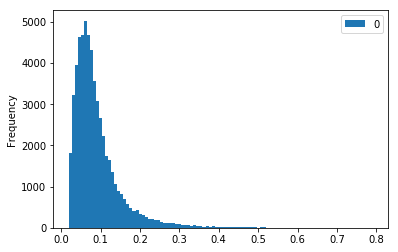

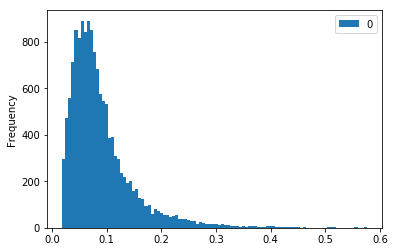

In [28]:
pd.DataFrame(y_train_pred_proba).plot.hist(bins=100)
pd.DataFrame(y_pred_proba).plot.hist(bins=100)

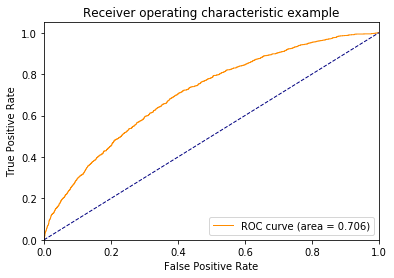

In [29]:
fpr = dict()
tpr = dict()
threshold = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], threshold[i] = roc_curve(abs(y_test-abs(i-1)),y_pred_proba)
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure()
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=1, label='ROC curve (area = %0.3f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Text(0.5,1,'2-class Precision-Recall curve: AP=0.20')

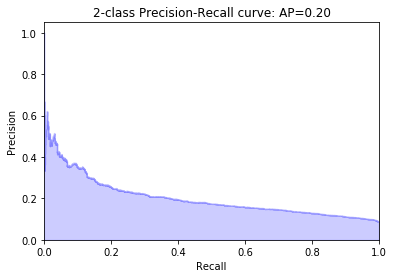

In [30]:
average_precision = average_precision_score(y_test, y_pred_proba)

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

## With Paramete Tuning

In [31]:
gbm2 = lgb.LGBMClassifier(
    class_weight='balanced',
    metric='binary_logloss'
)

In [32]:
gridParams = {
    'learning_rate': [0.01,0.03,0.05,0.07,0.09],
    'n_estimators': sp_randint(10, 100),
    'num_leaves': sp_randint(5, 100),
    'min_data_in_leaf': sp_randint(10,100),
    'min_split_gain': [0.0,0.2,0.4,0.6],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'seed' : [500,1000],
    'colsample_bytree' : [0.2,0.4,0.6,0.8,1.0],
    'subsample' : [0.2,0.4,0.6,0.8,1.0]
    }

In [33]:
start_time = time.time()
print('Fitting Model...')

grid = RandomizedSearchCV(gbm2,
                          gridParams,
                          n_iter=20, 
                          cv=3,
                          random_state=4444,
                          scoring='roc_auc',
                          n_jobs=-1)
grid.fit(X,y)

print('Model Fit Done')
print('Running time:', time.time()-start_time, 'sec')

Fitting Model...
Model Fit Done
Running time: 89.11556577682495 sec


In [34]:
print(grid.best_params_)

{'boosting_type': 'gbdt', 'colsample_bytree': 0.4, 'learning_rate': 0.05, 'min_data_in_leaf': 53, 'min_split_gain': 0.4, 'n_estimators': 75, 'num_leaves': 38, 'objective': 'binary', 'seed': 500, 'subsample': 0.8}


In [35]:
grid.predict_proba(X_test)[:,1]

array([ 0.47797374,  0.23819298,  0.41882119, ...,  0.30561124,
        0.22832958,  0.58073898])

In [36]:
print('Accuracy is {0:.3f}'.format(accuracy_score(y_test,grid.predict(X_test))))
print('f1 score is {0:.3f}'.format(f1_score(y_test,grid.predict(X_test))))
print('precision is {0:.3f}'.format(precision_score(y_test,grid.predict(X_test))))
print('recall is {0:.3f}'.format(recall_score(y_test,grid.predict(X_test))))
print('AUC is {0:.3f}'.format(roc_auc_score(y_test,grid.predict_proba(X_test)[:,1])))
print('Confusion matrix: \n {0}'.format(confusion_matrix(y_test,grid.predict(X_test))))

Accuracy is 0.695
f1 score is 0.260
precision is 0.165
recall is 0.611
AUC is 0.716
Confusion matrix: 
 [[9189 3875]
 [ 489  767]]


In [37]:
print('Training AUC is {0:.3f}'.format(roc_auc_score(y,grid.predict_proba(X)[:,1])))

Training AUC is 0.796


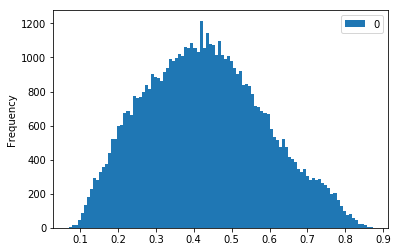

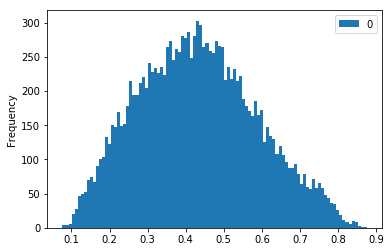

In [38]:
pd.DataFrame(grid.predict_proba(X)[:,1]).plot.hist(bins=100)
pd.DataFrame(grid.predict_proba(X_test)[:,1]).plot.hist(bins=100)

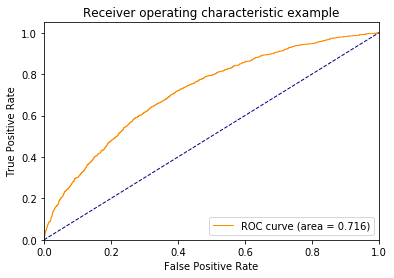

In [39]:
fpr = dict()
tpr = dict()
threshold = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], threshold[i] = roc_curve(abs(y_test-abs(i-1)),grid.predict_proba(X_test)[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure()
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=1, label='ROC curve (area = %0.3f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Text(0.5,1,'2-class Precision-Recall curve: AP=0.21')

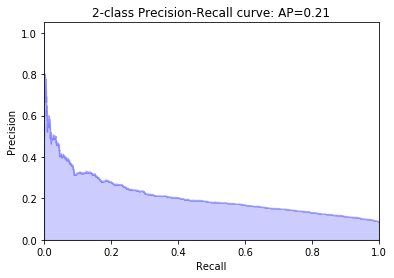

In [40]:
average_precision = average_precision_score(y_test, grid.predict_proba(X_test)[:,1])

precision, recall, _ = precision_recall_curve(y_test, grid.predict_proba(X_test)[:,1])

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

### Best Model

In [41]:
# {'boosting_type': 'gbdt', 
#  'colsample_bytree': 0.4, 
#  'learning_rate': 0.05, 
#  'min_data_in_leaf': 53, 
#  'min_split_gain': 0.4, 
#  'n_estimators': 75, 
#  'num_leaves': 38, 
#  'objective': 'binary', 
#  'seed': 500, 
#  'subsample': 0.8}

In [42]:
gbm3 = lgb.LGBMClassifier(
    boosting_type='gbdt', 
    colsample_bytree=0.4, 
    learning_rate=0.05,
    min_data_in_leaf=53, 
    min_split_gain=0.4, 
    n_estimators=75, 
    num_leaves=38, 
    objective='binary',
    seed=500, 
    subsample=0.8,
    class_weight='balanced',
    metric='binary_logloss'
)

In [43]:
gbm3.fit(X, y)#,
        #eval_set=[(X, y)],
        #eval_metric='logloss',
        #early_stopping_rounds=10)

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=0.4, learning_rate=0.05, max_depth=-1,
        metric='binary_logloss', min_child_samples=20,
        min_child_weight=0.001, min_data_in_leaf=53, min_split_gain=0.4,
        n_estimators=75, n_jobs=-1, num_leaves=38, objective='binary',
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, seed=500,
        silent=True, subsample=0.8, subsample_for_bin=200000,
        subsample_freq=1)

In [44]:
y_pred = gbm3.predict_proba(X_test)

In [45]:
y_pred

array([[ 0.52202626,  0.47797374],
       [ 0.76180702,  0.23819298],
       [ 0.58117881,  0.41882119],
       ..., 
       [ 0.69438876,  0.30561124],
       [ 0.77167042,  0.22832958],
       [ 0.41926102,  0.58073898]])

In [46]:
print('Training AUC is {0:.3f}'.format(roc_auc_score(y,gbm3.predict_proba(X)[:,1])))

print('f1 score is {0:.3f}'.format(f1_score(y_test,gbm3.predict(X_test))))
print('precision is {0:.3f}'.format(precision_score(y_test,gbm3.predict(X_test))))
print('recall is {0:.3f}'.format(recall_score(y_test,gbm3.predict(X_test))))
print('AUC is {0:.3f}'.format(roc_auc_score(y_test,gbm3.predict_proba(X_test)[:,1])))
print('Confusion matrix: \n {0}'.format(confusion_matrix(y_test,gbm3.predict(X_test)))) 

Training AUC is 0.796
f1 score is 0.260
precision is 0.165
recall is 0.611
AUC is 0.716
Confusion matrix: 
 [[9189 3875]
 [ 489  767]]


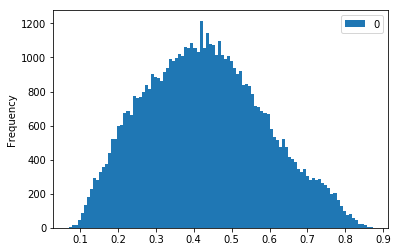

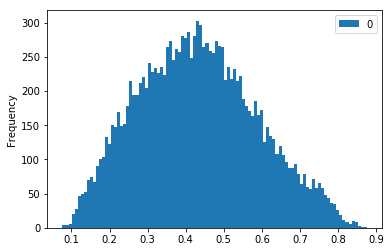

In [47]:
pd.DataFrame(gbm3.predict_proba(X)[:,1]).plot.hist(bins=100)
pd.DataFrame(gbm3.predict_proba(X_test)[:,1]).plot.hist(bins=100)

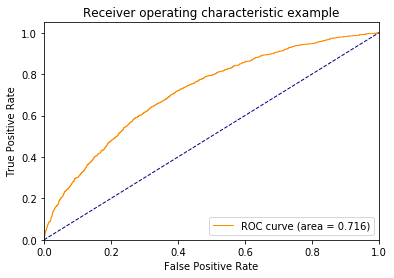

In [48]:
fpr = dict()
tpr = dict()
threshold = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], threshold[i] = roc_curve(abs(y_test-abs(i-1)),gbm3.predict_proba(X_test)[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure()
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=1, label='ROC curve (area = %0.3f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Text(0.5,1,'2-class Precision-Recall curve: AP=0.21')

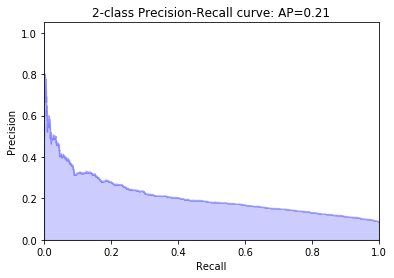

In [49]:
average_precision = average_precision_score(y_test, gbm3.predict_proba(X_test)[:,1])

precision, recall, _ = precision_recall_curve(y_test, gbm3.predict_proba(X_test)[:,1])

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

In [50]:
importance = pd.DataFrame(gbm3.feature_importances_, index=X_test.columns.values, columns=['Importance']).sort_values(by='Importance', ascending=False)
importance.round(5)

,Importance
rs15_comna,140
mr_allowed_q4,91
mr_allowed_q2,90
mr_allowed_q1,83
GPI4_3720,82
age,67
mr_allowed_q3,62
GPI4_3330,51
GPI4_8320,46
PCP_visits_q4,40


### Summry Table

In [51]:
print(pd.options.display.max_rows)
print(pd.options.display.max_columns)

400
400


In [52]:
pd.options.display.max_columns=999
print(pd.options.display.max_rows)
print(pd.options.display.max_columns)

400
999


In [53]:
temppd = pd.concat([X_test,y_test,pd.DataFrame(gbm3.predict_proba(X_test)[:,1], \
                               columns=['proba'])], axis=1)
temppd['rank'] = (temppd['proba']<0.4)*1 + (temppd['proba']<0.5)*1 + \
                 (temppd['proba']<0.6)*1 + (temppd['proba']<0.7)*1 + \
                 (temppd['proba']<0.8)*1 + (temppd['proba']<0.9)*1 + \
                 1

In [54]:
temppd.head(100)

,age,rs15_comna,mr_allowed_q1,mr_allowed_q2,mr_allowed_q3,mr_allowed_q4,ER_visits_q1,ER_visits_q2,ER_visits_q3,ER_visits_q4,PCP_visits_q1,PCP_visits_q2,PCP_visits_q3,PCP_visits_q4,Spec_visits_q1,Spec_visits_q2,Spec_visits_q3,Spec_visits_q4,UC_visits_q1,UC_visits_q2,UC_visits_q3,UC_visits_q4,OP_visits_q1,OP_visits_q2,OP_visits_q3,OP_visits_q4,admits_q1,admits_q2,admits_q3,admits_q4,hfadmits_q1,hfadmits_q2,hfadmits_q3,hfadmits_q4,days_admits_q1,days_admits_q2,days_admits_q3,days_admits_q4,days_hfadmits_q1,days_hfadmits_q2,days_hfadmits_q3,days_hfadmits_q4,GPI4_0120,GPI4_0340,GPI4_1710,GPI4_1899,GPI4_2210,GPI4_2400,GPI4_4420,GPI4_5710,GPI4_5816,GPI4_6510,GPI4_6599,GPI4_6610,GPI4_7260,GPI4_7510,GPI4_0500,GPI4_2725,GPI4_3320,GPI4_3620,GPI4_3720,GPI4_3940,GPI4_5685,GPI4_6020,GPI4_6800,GPI4_7970,GPI4_8610,GPI4_8630,GPI4_8680,GPI4_9015,GPI4_9410,GPI4_9720,GPI4_2720,GPI4_3330,GPI4_3699,GPI4_4220,GPI4_0210,GPI4_1140,GPI4_1622,GPI4_2810,GPI4_3750,GPI4_4920,GPI4_4927,GPI4_7210,GPI4_9055,GPI4_0199,GPI4_1250,GPI4_1600,GPI4_3400,GPI4_3615,GPI4_4450,GPI4_8210,GPI4_8310,GPI4_8320,GPI4_0230,GPI4_1699,GPI4_2710,GPI4_3210,GPI4_3945,GPI4_5820,GPI4_8337,GPI4_9705,GPI4_0400,GPI4_3530,GPI4_4930,GPI4_3310,GPI4_3540,GPI4_3760,GPI4_3610,GPI4_4410,GPI4_4440,GPI4_3090,GPI4_3120,GPI4_4699,GPI4_9010,GPI4_5300,GPI4_5812,GPI4_5818,GPI4_7320,GPI4_1720,GPI4_4014,GPI4_4660,GPI4_5830,GPI4_8333,GPI4_4240,GPI4_5803,GPI4_2760,GPI4_5025,GPI4_5230,GPI4_8810,GPI4_9085,GPI4_0220,GPI4_8515,GPI4_2310,GPI4_2140,GPI4_6499,GPI4_8672,GPI4_8815,GPI4_1240,GPI4_3890,GPI4_5410,GPI4_8520,GPI4_3799,GPI4_9077,GPI4_3004,GPI4_8633,GPI4_4140,GPI4_5535,GPI4_5720,GPI4_5915,GPI4_5925,GPI4_5940,GPI4_5907,GPI4_7250,GPI4_5920,GPI4_9310,GPI4_9940,GPI4_2755,GPI4_0110,GPI4_2770,GPI4_6520,GPI4_4230,GPI4_9045,GPI4_6205,GPI4_2799,GPI4_4155,GPI4_4710,GPI4_6025,GPI4_5120,GPI4_3910,GPI4_2730,GPI4_4620,GPI4_4650,GPI4_4730,GPI4_8910,GPI4_4330,GPI4_3640,GPI4_4310,GPI4_8230,GPI4_6910,GPI4_7330,GPI4_3930,GPI4_5240,GPI4_8799,GPI4_7720,GPI4_7820,GPI4_3920,GPI4_8220,GPI4_2110,GPI4_9939,GPI4_3220,GPI4_8660,GPI4_9770,GPI4_3005,GPI4_6010,GPI4_5250,GPI4_6410,GPI4_9006,GPI4_4399,GPI4_7975,GPI4_6040,GPI4_8240,GPI4_1210,GPI4_5510,GPI4_6210,GPI4_6420,GPI4_5020,GPI4_9021,GPI4_5280,GPI4_8625,GPI4_8710,GPI4_9037,GPI4_6740,GPI4_8825,GPI4_5420,GPI4_9005,GPI4_2728,GPI4_7851,GPI4_2830,GPI4_2170,GPI4_1615,GPI4_6628,GPI4_4430,GPI4_9775,GPI4_4910,GPI4_9065,GPI4_1300,GPI4_9025,GPI4_7940,GPI4_2717,GPI4_3950,GPI4_8635,GPI4_1630,GPI4_2130,GPI4_4250,GPI4_7710,GPI4_9070,GPI4_9945,GPI4_7600,GPI4_8920,GPI4_3625,GPI4_9094,GPI4_5245,GPI4_8835,GPI4_3617,GPI4_5255,GPI4_5670,GPI4_3710,GPI4_4320,GPI4_4030,GPI4_0310,GPI4_9662,GPI4_4925,GPI4_0130,GPI4_9097,GPI4_5430,GPI4_8730,GPI4_8840,GPI4_1100,GPI4_5630,GPI4_9840,GPI4_0700,GPI4_6810,GPI4_6629,GPI4_3999,GPI4_5620,GPI4_4445,GPI4_3520,GPI4_1500,GPI4_8915,GPI4_9090,GPI4_0240,GPI4_1627,GPI4_6140,GPI4_6110,GPI4_0350,GPI4_8850,GPI4_4610,GPI4_8620,GPI4_1623,GPI4_4840,GPI4_7910,GPI4_7220,GPI4_8999,GPI4_2750,GPI4_9020,GPI4_2153,GPI4_8299,GPI4_2220,GPI4_7960,GPI4_5930,GPI4_4120,GPI4_5220,GPI4_9654,GPI4_0900,GPI4_9210,GPI4_4150,GPI4_5910,GPI4_4016,GPI4_8120,GPI4_4820,GPI4_9735,GPI4_6050,GPI4_9710,GPI4_7980,GPI4_6256,GPI4_4070,GPI4_9030,GPI4_9975,GPI4_7841,GPI4_7310,GPI4_9509,GPI4_9715,GPI4_9078,GPI4_4630,GPI4_3935,GPI4_9440,GPI4_1235,GPI4_5210,GPI4_9646,GPI4_4830,GPI4_5030,GPI4_1629,GPI4_4999,GPI4_5258,GPI4_8650,GPI4_5399,GPI4_5650,GPI4_7811,GPI4_6240,GPI4_1640,GPI4_7315,GPI4_3800,GPI4_2600,GPI4_4099,GPI4_6670,GPI4_4210,GPI4_7999,GPI4_5950,GPI4_4299,GPI4_3110,GPI4_9860,GPI4_9035,GPI4_4555,GPI4_4530,GPI4_8410,GPI4_6700,GPI4_3510,GPI4_4225,GPI4_0353,GPI4_8740,GPI4_7440,GPI4_8010,GPI4_1800,GPI4_2145,GPI4_6660,GPI4_6260,GPI4_2499,GPI4_6299,GPI4_7217,GPI4_5810,GPI4_5440,GPI4_8030,GPI4_6899,GPI4_8640,GPI4_1220,GPI4_7520,GPI4_4013,GPI4_4017,GPI4_9022,GPI4_6250,GPI4_3040,GPI4_7831,GPI4_3045,GPI4_2515,GPI4_9539,GPI4_4899,GPI4_7821,GPI4_8125,GPI4_5028,GPI4_3020,GPI4_4340,GPI4_8665,GPI4_2175,GPI4_3017,GPI4_4460,

In [55]:
pd.concat([
    temppd.groupby(['rank'])['rank'].count(),
    temppd.groupby(['rank']).mean()
], axis=1)

,rank,age,rs15_comna,mr_allowed_q1,mr_allowed_q2,mr_allowed_q3,mr_allowed_q4,ER_visits_q1,ER_visits_q2,ER_visits_q3,ER_visits_q4,PCP_visits_q1,PCP_visits_q2,PCP_visits_q3,PCP_visits_q4,Spec_visits_q1,Spec_visits_q2,Spec_visits_q3,Spec_visits_q4,UC_visits_q1,UC_visits_q2,UC_visits_q3,UC_visits_q4,OP_visits_q1,OP_visits_q2,OP_visits_q3,OP_visits_q4,admits_q1,admits_q2,admits_q3,admits_q4,hfadmits_q1,hfadmits_q2,hfadmits_q3,hfadmits_q4,days_admits_q1,days_admits_q2,days_admits_q3,days_admits_q4,days_hfadmits_q1,days_hfadmits_q2,days_hfadmits_q3,days_hfadmits_q4,GPI4_0120,GPI4_0340,GPI4_1710,GPI4_1899,GPI4_2210,GPI4_2400,GPI4_4420,GPI4_5710,GPI4_5816,GPI4_6510,GPI4_6599,GPI4_6610,GPI4_7260,GPI4_7510,GPI4_0500,GPI4_2725,GPI4_3320,GPI4_3620,GPI4_3720,GPI4_3940,GPI4_5685,GPI4_6020,GPI4_6800,GPI4_7970,GPI4_8610,GPI4_8630,GPI4_8680,GPI4_9015,GPI4_9410,GPI4_9720,GPI4_2720,GPI4_3330,GPI4_3699,GPI4_4220,GPI4_0210,GPI4_1140,GPI4_1622,GPI4_2810,GPI4_3750,GPI4_4920,GPI4_4927,GPI4_7210,GPI4_9055,GPI4_0199,GPI4_1250,GPI4_1600,GPI4_3400,GPI4_3615,GPI4_4450,GPI4_8210,GPI4_8310,GPI4_8320,GPI4_0230,GPI4_1699,GPI4_2710,GPI4_3210,GPI4_3945,GPI4_5820,GPI4_8337,GPI4_9705,GPI4_0400,GPI4_3530,GPI4_4930,GPI4_3310,GPI4_3540,GPI4_3760,GPI4_3610,GPI4_4410,GPI4_4440,GPI4_3090,GPI4_3120,GPI4_4699,GPI4_9010,GPI4_5300,GPI4_5812,GPI4_5818,GPI4_7320,GPI4_1720,GPI4_4014,GPI4_4660,GPI4_5830,GPI4_8333,GPI4_4240,GPI4_5803,GPI4_2760,GPI4_5025,GPI4_5230,GPI4_8810,GPI4_9085,GPI4_0220,GPI4_8515,GPI4_2310,GPI4_2140,GPI4_6499,GPI4_8672,GPI4_8815,GPI4_1240,GPI4_3890,GPI4_5410,GPI4_8520,GPI4_3799,GPI4_9077,GPI4_3004,GPI4_8633,GPI4_4140,GPI4_5535,GPI4_5720,GPI4_5915,GPI4_5925,GPI4_5940,GPI4_5907,GPI4_7250,GPI4_5920,GPI4_9310,GPI4_9940,GPI4_2755,GPI4_0110,GPI4_2770,GPI4_6520,GPI4_4230,GPI4_9045,GPI4_6205,GPI4_2799,GPI4_4155,GPI4_4710,GPI4_6025,GPI4_5120,GPI4_3910,GPI4_2730,GPI4_4620,GPI4_4650,GPI4_4730,GPI4_8910,GPI4_4330,GPI4_3640,GPI4_4310,GPI4_8230,GPI4_6910,GPI4_7330,GPI4_3930,GPI4_5240,GPI4_8799,GPI4_7720,GPI4_7820,GPI4_3920,GPI4_8220,GPI4_2110,GPI4_9939,GPI4_3220,GPI4_8660,GPI4_9770,GPI4_3005,GPI4_6010,GPI4_5250,GPI4_6410,GPI4_9006,GPI4_4399,GPI4_7975,GPI4_6040,GPI4_8240,GPI4_1210,GPI4_5510,GPI4_6210,GPI4_6420,GPI4_5020,GPI4_9021,GPI4_5280,GPI4_8625,GPI4_8710,GPI4_9037,GPI4_6740,GPI4_8825,GPI4_5420,GPI4_9005,GPI4_2728,GPI4_7851,GPI4_2830,GPI4_2170,GPI4_1615,GPI4_6628,GPI4_4430,GPI4_9775,GPI4_4910,GPI4_9065,GPI4_1300,GPI4_9025,GPI4_7940,GPI4_2717,GPI4_3950,GPI4_8635,GPI4_1630,GPI4_2130,GPI4_4250,GPI4_7710,GPI4_9070,GPI4_9945,GPI4_7600,GPI4_8920,GPI4_3625,GPI4_9094,GPI4_5245,GPI4_8835,GPI4_3617,GPI4_5255,GPI4_5670,GPI4_3710,GPI4_4320,GPI4_4030,GPI4_0310,GPI4_9662,GPI4_4925,GPI4_0130,GPI4_9097,GPI4_5430,GPI4_8730,GPI4_8840,GPI4_1100,GPI4_5630,GPI4_9840,GPI4_0700,GPI4_6810,GPI4_6629,GPI4_3999,GPI4_5620,GPI4_4445,GPI4_3520,GPI4_1500,GPI4_8915,GPI4_9090,GPI4_0240,GPI4_1627,GPI4_6140,GPI4_6110,GPI4_0350,GPI4_8850,GPI4_4610,GPI4_8620,GPI4_1623,GPI4_4840,GPI4_7910,GPI4_7220,GPI4_8999,GPI4_2750,GPI4_9020,GPI4_2153,GPI4_8299,GPI4_2220,GPI4_7960,GPI4_5930,GPI4_4120,GPI4_5220,GPI4_9654,GPI4_0900,GPI4_9210,GPI4_4150,GPI4_5910,GPI4_4016,GPI4_8120,GPI4_4820,GPI4_9735,GPI4_6050,GPI4_9710,GPI4_7980,GPI4_6256,GPI4_4070,GPI4_9030,GPI4_9975,GPI4_7841,GPI4_7310,GPI4_9509,GPI4_9715,GPI4_9078,GPI4_4630,GPI4_3935,GPI4_9440,GPI4_1235,GPI4_5210,GPI4_9646,GPI4_4830,GPI4_5030,GPI4_1629,GPI4_4999,GPI4_5258,GPI4_8650,GPI4_5399,GPI4_5650,GPI4_7811,GPI4_6240,GPI4_1640,GPI4_7315,GPI4_3800,GPI4_2600,GPI4_4099,GPI4_6670,GPI4_4210,GPI4_7999,GPI4_5950,GPI4_4299,GPI4_3110,GPI4_9860,GPI4_9035,GPI4_4555,GPI4_4530,GPI4_8410,GPI4_6700,GPI4_3510,GPI4_4225,GPI4_0353,GPI4_8740,GPI4_7440,GPI4_8010,GPI4_1800,GPI4_2145,GPI4_6660,GPI4_6260,GPI4_2499,GPI4_6299,GPI4_7217,GPI4_5810,GPI4_5440,GPI4_8030,GPI4_6899,GPI4_8640,GPI4_1220,GPI4_7520,GPI4_4013,GPI4_4017,GPI4_9022,GPI4_6250,GPI4_3040,GPI4_7831,GPI4_3045,GPI4_2515,GPI4_9539,GPI4_4899,GPI4_7821,GPI4_8125,GPI4_5028,GPI4_3020,GPI4_4340,GPI4_8665,GPI4_2175,GPI4_3017,GPI4_

In [56]:
pd.concat([
    temppd.groupby(['rank'])['rank'].count(),
    temppd.groupby(['rank']).max()
], axis=1)

,rank,age,rs15_comna,mr_allowed_q1,mr_allowed_q2,mr_allowed_q3,mr_allowed_q4,ER_visits_q1,ER_visits_q2,ER_visits_q3,ER_visits_q4,PCP_visits_q1,PCP_visits_q2,PCP_visits_q3,PCP_visits_q4,Spec_visits_q1,Spec_visits_q2,Spec_visits_q3,Spec_visits_q4,UC_visits_q1,UC_visits_q2,UC_visits_q3,UC_visits_q4,OP_visits_q1,OP_visits_q2,OP_visits_q3,OP_visits_q4,admits_q1,admits_q2,admits_q3,admits_q4,hfadmits_q1,hfadmits_q2,hfadmits_q3,hfadmits_q4,days_admits_q1,days_admits_q2,days_admits_q3,days_admits_q4,days_hfadmits_q1,days_hfadmits_q2,days_hfadmits_q3,days_hfadmits_q4,GPI4_0120,GPI4_0340,GPI4_1710,GPI4_1899,GPI4_2210,GPI4_2400,GPI4_4420,GPI4_5710,GPI4_5816,GPI4_6510,GPI4_6599,GPI4_6610,GPI4_7260,GPI4_7510,GPI4_0500,GPI4_2725,GPI4_3320,GPI4_3620,GPI4_3720,GPI4_3940,GPI4_5685,GPI4_6020,GPI4_6800,GPI4_7970,GPI4_8610,GPI4_8630,GPI4_8680,GPI4_9015,GPI4_9410,GPI4_9720,GPI4_2720,GPI4_3330,GPI4_3699,GPI4_4220,GPI4_0210,GPI4_1140,GPI4_1622,GPI4_2810,GPI4_3750,GPI4_4920,GPI4_4927,GPI4_7210,GPI4_9055,GPI4_0199,GPI4_1250,GPI4_1600,GPI4_3400,GPI4_3615,GPI4_4450,GPI4_8210,GPI4_8310,GPI4_8320,GPI4_0230,GPI4_1699,GPI4_2710,GPI4_3210,GPI4_3945,GPI4_5820,GPI4_8337,GPI4_9705,GPI4_0400,GPI4_3530,GPI4_4930,GPI4_3310,GPI4_3540,GPI4_3760,GPI4_3610,GPI4_4410,GPI4_4440,GPI4_3090,GPI4_3120,GPI4_4699,GPI4_9010,GPI4_5300,GPI4_5812,GPI4_5818,GPI4_7320,GPI4_1720,GPI4_4014,GPI4_4660,GPI4_5830,GPI4_8333,GPI4_4240,GPI4_5803,GPI4_2760,GPI4_5025,GPI4_5230,GPI4_8810,GPI4_9085,GPI4_0220,GPI4_8515,GPI4_2310,GPI4_2140,GPI4_6499,GPI4_8672,GPI4_8815,GPI4_1240,GPI4_3890,GPI4_5410,GPI4_8520,GPI4_3799,GPI4_9077,GPI4_3004,GPI4_8633,GPI4_4140,GPI4_5535,GPI4_5720,GPI4_5915,GPI4_5925,GPI4_5940,GPI4_5907,GPI4_7250,GPI4_5920,GPI4_9310,GPI4_9940,GPI4_2755,GPI4_0110,GPI4_2770,GPI4_6520,GPI4_4230,GPI4_9045,GPI4_6205,GPI4_2799,GPI4_4155,GPI4_4710,GPI4_6025,GPI4_5120,GPI4_3910,GPI4_2730,GPI4_4620,GPI4_4650,GPI4_4730,GPI4_8910,GPI4_4330,GPI4_3640,GPI4_4310,GPI4_8230,GPI4_6910,GPI4_7330,GPI4_3930,GPI4_5240,GPI4_8799,GPI4_7720,GPI4_7820,GPI4_3920,GPI4_8220,GPI4_2110,GPI4_9939,GPI4_3220,GPI4_8660,GPI4_9770,GPI4_3005,GPI4_6010,GPI4_5250,GPI4_6410,GPI4_9006,GPI4_4399,GPI4_7975,GPI4_6040,GPI4_8240,GPI4_1210,GPI4_5510,GPI4_6210,GPI4_6420,GPI4_5020,GPI4_9021,GPI4_5280,GPI4_8625,GPI4_8710,GPI4_9037,GPI4_6740,GPI4_8825,GPI4_5420,GPI4_9005,GPI4_2728,GPI4_7851,GPI4_2830,GPI4_2170,GPI4_1615,GPI4_6628,GPI4_4430,GPI4_9775,GPI4_4910,GPI4_9065,GPI4_1300,GPI4_9025,GPI4_7940,GPI4_2717,GPI4_3950,GPI4_8635,GPI4_1630,GPI4_2130,GPI4_4250,GPI4_7710,GPI4_9070,GPI4_9945,GPI4_7600,GPI4_8920,GPI4_3625,GPI4_9094,GPI4_5245,GPI4_8835,GPI4_3617,GPI4_5255,GPI4_5670,GPI4_3710,GPI4_4320,GPI4_4030,GPI4_0310,GPI4_9662,GPI4_4925,GPI4_0130,GPI4_9097,GPI4_5430,GPI4_8730,GPI4_8840,GPI4_1100,GPI4_5630,GPI4_9840,GPI4_0700,GPI4_6810,GPI4_6629,GPI4_3999,GPI4_5620,GPI4_4445,GPI4_3520,GPI4_1500,GPI4_8915,GPI4_9090,GPI4_0240,GPI4_1627,GPI4_6140,GPI4_6110,GPI4_0350,GPI4_8850,GPI4_4610,GPI4_8620,GPI4_1623,GPI4_4840,GPI4_7910,GPI4_7220,GPI4_8999,GPI4_2750,GPI4_9020,GPI4_2153,GPI4_8299,GPI4_2220,GPI4_7960,GPI4_5930,GPI4_4120,GPI4_5220,GPI4_9654,GPI4_0900,GPI4_9210,GPI4_4150,GPI4_5910,GPI4_4016,GPI4_8120,GPI4_4820,GPI4_9735,GPI4_6050,GPI4_9710,GPI4_7980,GPI4_6256,GPI4_4070,GPI4_9030,GPI4_9975,GPI4_7841,GPI4_7310,GPI4_9509,GPI4_9715,GPI4_9078,GPI4_4630,GPI4_3935,GPI4_9440,GPI4_1235,GPI4_5210,GPI4_9646,GPI4_4830,GPI4_5030,GPI4_1629,GPI4_4999,GPI4_5258,GPI4_8650,GPI4_5399,GPI4_5650,GPI4_7811,GPI4_6240,GPI4_1640,GPI4_7315,GPI4_3800,GPI4_2600,GPI4_4099,GPI4_6670,GPI4_4210,GPI4_7999,GPI4_5950,GPI4_4299,GPI4_3110,GPI4_9860,GPI4_9035,GPI4_4555,GPI4_4530,GPI4_8410,GPI4_6700,GPI4_3510,GPI4_4225,GPI4_0353,GPI4_8740,GPI4_7440,GPI4_8010,GPI4_1800,GPI4_2145,GPI4_6660,GPI4_6260,GPI4_2499,GPI4_6299,GPI4_7217,GPI4_5810,GPI4_5440,GPI4_8030,GPI4_6899,GPI4_8640,GPI4_1220,GPI4_7520,GPI4_4013,GPI4_4017,GPI4_9022,GPI4_6250,GPI4_3040,GPI4_7831,GPI4_3045,GPI4_2515,GPI4_9539,GPI4_4899,GPI4_7821,GPI4_8125,GPI4_5028,GPI4_3020,GPI4_4340,GPI4_8665,GPI4_2175,GPI4_3017,GPI4_

In [57]:
pd.concat([
    temppd.groupby(['rank'])['rank'].count(),
    temppd.groupby(['rank']).min()
], axis=1)

,rank,age,rs15_comna,mr_allowed_q1,mr_allowed_q2,mr_allowed_q3,mr_allowed_q4,ER_visits_q1,ER_visits_q2,ER_visits_q3,ER_visits_q4,PCP_visits_q1,PCP_visits_q2,PCP_visits_q3,PCP_visits_q4,Spec_visits_q1,Spec_visits_q2,Spec_visits_q3,Spec_visits_q4,UC_visits_q1,UC_visits_q2,UC_visits_q3,UC_visits_q4,OP_visits_q1,OP_visits_q2,OP_visits_q3,OP_visits_q4,admits_q1,admits_q2,admits_q3,admits_q4,hfadmits_q1,hfadmits_q2,hfadmits_q3,hfadmits_q4,days_admits_q1,days_admits_q2,days_admits_q3,days_admits_q4,days_hfadmits_q1,days_hfadmits_q2,days_hfadmits_q3,days_hfadmits_q4,GPI4_0120,GPI4_0340,GPI4_1710,GPI4_1899,GPI4_2210,GPI4_2400,GPI4_4420,GPI4_5710,GPI4_5816,GPI4_6510,GPI4_6599,GPI4_6610,GPI4_7260,GPI4_7510,GPI4_0500,GPI4_2725,GPI4_3320,GPI4_3620,GPI4_3720,GPI4_3940,GPI4_5685,GPI4_6020,GPI4_6800,GPI4_7970,GPI4_8610,GPI4_8630,GPI4_8680,GPI4_9015,GPI4_9410,GPI4_9720,GPI4_2720,GPI4_3330,GPI4_3699,GPI4_4220,GPI4_0210,GPI4_1140,GPI4_1622,GPI4_2810,GPI4_3750,GPI4_4920,GPI4_4927,GPI4_7210,GPI4_9055,GPI4_0199,GPI4_1250,GPI4_1600,GPI4_3400,GPI4_3615,GPI4_4450,GPI4_8210,GPI4_8310,GPI4_8320,GPI4_0230,GPI4_1699,GPI4_2710,GPI4_3210,GPI4_3945,GPI4_5820,GPI4_8337,GPI4_9705,GPI4_0400,GPI4_3530,GPI4_4930,GPI4_3310,GPI4_3540,GPI4_3760,GPI4_3610,GPI4_4410,GPI4_4440,GPI4_3090,GPI4_3120,GPI4_4699,GPI4_9010,GPI4_5300,GPI4_5812,GPI4_5818,GPI4_7320,GPI4_1720,GPI4_4014,GPI4_4660,GPI4_5830,GPI4_8333,GPI4_4240,GPI4_5803,GPI4_2760,GPI4_5025,GPI4_5230,GPI4_8810,GPI4_9085,GPI4_0220,GPI4_8515,GPI4_2310,GPI4_2140,GPI4_6499,GPI4_8672,GPI4_8815,GPI4_1240,GPI4_3890,GPI4_5410,GPI4_8520,GPI4_3799,GPI4_9077,GPI4_3004,GPI4_8633,GPI4_4140,GPI4_5535,GPI4_5720,GPI4_5915,GPI4_5925,GPI4_5940,GPI4_5907,GPI4_7250,GPI4_5920,GPI4_9310,GPI4_9940,GPI4_2755,GPI4_0110,GPI4_2770,GPI4_6520,GPI4_4230,GPI4_9045,GPI4_6205,GPI4_2799,GPI4_4155,GPI4_4710,GPI4_6025,GPI4_5120,GPI4_3910,GPI4_2730,GPI4_4620,GPI4_4650,GPI4_4730,GPI4_8910,GPI4_4330,GPI4_3640,GPI4_4310,GPI4_8230,GPI4_6910,GPI4_7330,GPI4_3930,GPI4_5240,GPI4_8799,GPI4_7720,GPI4_7820,GPI4_3920,GPI4_8220,GPI4_2110,GPI4_9939,GPI4_3220,GPI4_8660,GPI4_9770,GPI4_3005,GPI4_6010,GPI4_5250,GPI4_6410,GPI4_9006,GPI4_4399,GPI4_7975,GPI4_6040,GPI4_8240,GPI4_1210,GPI4_5510,GPI4_6210,GPI4_6420,GPI4_5020,GPI4_9021,GPI4_5280,GPI4_8625,GPI4_8710,GPI4_9037,GPI4_6740,GPI4_8825,GPI4_5420,GPI4_9005,GPI4_2728,GPI4_7851,GPI4_2830,GPI4_2170,GPI4_1615,GPI4_6628,GPI4_4430,GPI4_9775,GPI4_4910,GPI4_9065,GPI4_1300,GPI4_9025,GPI4_7940,GPI4_2717,GPI4_3950,GPI4_8635,GPI4_1630,GPI4_2130,GPI4_4250,GPI4_7710,GPI4_9070,GPI4_9945,GPI4_7600,GPI4_8920,GPI4_3625,GPI4_9094,GPI4_5245,GPI4_8835,GPI4_3617,GPI4_5255,GPI4_5670,GPI4_3710,GPI4_4320,GPI4_4030,GPI4_0310,GPI4_9662,GPI4_4925,GPI4_0130,GPI4_9097,GPI4_5430,GPI4_8730,GPI4_8840,GPI4_1100,GPI4_5630,GPI4_9840,GPI4_0700,GPI4_6810,GPI4_6629,GPI4_3999,GPI4_5620,GPI4_4445,GPI4_3520,GPI4_1500,GPI4_8915,GPI4_9090,GPI4_0240,GPI4_1627,GPI4_6140,GPI4_6110,GPI4_0350,GPI4_8850,GPI4_4610,GPI4_8620,GPI4_1623,GPI4_4840,GPI4_7910,GPI4_7220,GPI4_8999,GPI4_2750,GPI4_9020,GPI4_2153,GPI4_8299,GPI4_2220,GPI4_7960,GPI4_5930,GPI4_4120,GPI4_5220,GPI4_9654,GPI4_0900,GPI4_9210,GPI4_4150,GPI4_5910,GPI4_4016,GPI4_8120,GPI4_4820,GPI4_9735,GPI4_6050,GPI4_9710,GPI4_7980,GPI4_6256,GPI4_4070,GPI4_9030,GPI4_9975,GPI4_7841,GPI4_7310,GPI4_9509,GPI4_9715,GPI4_9078,GPI4_4630,GPI4_3935,GPI4_9440,GPI4_1235,GPI4_5210,GPI4_9646,GPI4_4830,GPI4_5030,GPI4_1629,GPI4_4999,GPI4_5258,GPI4_8650,GPI4_5399,GPI4_5650,GPI4_7811,GPI4_6240,GPI4_1640,GPI4_7315,GPI4_3800,GPI4_2600,GPI4_4099,GPI4_6670,GPI4_4210,GPI4_7999,GPI4_5950,GPI4_4299,GPI4_3110,GPI4_9860,GPI4_9035,GPI4_4555,GPI4_4530,GPI4_8410,GPI4_6700,GPI4_3510,GPI4_4225,GPI4_0353,GPI4_8740,GPI4_7440,GPI4_8010,GPI4_1800,GPI4_2145,GPI4_6660,GPI4_6260,GPI4_2499,GPI4_6299,GPI4_7217,GPI4_5810,GPI4_5440,GPI4_8030,GPI4_6899,GPI4_8640,GPI4_1220,GPI4_7520,GPI4_4013,GPI4_4017,GPI4_9022,GPI4_6250,GPI4_3040,GPI4_7831,GPI4_3045,GPI4_2515,GPI4_9539,GPI4_4899,GPI4_7821,GPI4_8125,GPI4_5028,GPI4_3020,GPI4_4340,GPI4_8665,GPI4_2175,GPI4_3017,GPI4_

In [58]:
pd.concat([
    temppd.groupby(['rank'])['rank'].count(),
    temppd.groupby(['rank']).std()
], axis=1)

,rank,age,rs15_comna,mr_allowed_q1,mr_allowed_q2,mr_allowed_q3,mr_allowed_q4,ER_visits_q1,ER_visits_q2,ER_visits_q3,ER_visits_q4,PCP_visits_q1,PCP_visits_q2,PCP_visits_q3,PCP_visits_q4,Spec_visits_q1,Spec_visits_q2,Spec_visits_q3,Spec_visits_q4,UC_visits_q1,UC_visits_q2,UC_visits_q3,UC_visits_q4,OP_visits_q1,OP_visits_q2,OP_visits_q3,OP_visits_q4,admits_q1,admits_q2,admits_q3,admits_q4,hfadmits_q1,hfadmits_q2,hfadmits_q3,hfadmits_q4,days_admits_q1,days_admits_q2,days_admits_q3,days_admits_q4,days_hfadmits_q1,days_hfadmits_q2,days_hfadmits_q3,days_hfadmits_q4,GPI4_0120,GPI4_0340,GPI4_1710,GPI4_1899,GPI4_2210,GPI4_2400,GPI4_4420,GPI4_5710,GPI4_5816,GPI4_6510,GPI4_6599,GPI4_6610,GPI4_7260,GPI4_7510,GPI4_0500,GPI4_2725,GPI4_3320,GPI4_3620,GPI4_3720,GPI4_3940,GPI4_5685,GPI4_6020,GPI4_6800,GPI4_7970,GPI4_8610,GPI4_8630,GPI4_8680,GPI4_9015,GPI4_9410,GPI4_9720,GPI4_2720,GPI4_3330,GPI4_3699,GPI4_4220,GPI4_0210,GPI4_1140,GPI4_1622,GPI4_2810,GPI4_3750,GPI4_4920,GPI4_4927,GPI4_7210,GPI4_9055,GPI4_0199,GPI4_1250,GPI4_1600,GPI4_3400,GPI4_3615,GPI4_4450,GPI4_8210,GPI4_8310,GPI4_8320,GPI4_0230,GPI4_1699,GPI4_2710,GPI4_3210,GPI4_3945,GPI4_5820,GPI4_8337,GPI4_9705,GPI4_0400,GPI4_3530,GPI4_4930,GPI4_3310,GPI4_3540,GPI4_3760,GPI4_3610,GPI4_4410,GPI4_4440,GPI4_3090,GPI4_3120,GPI4_4699,GPI4_9010,GPI4_5300,GPI4_5812,GPI4_5818,GPI4_7320,GPI4_1720,GPI4_4014,GPI4_4660,GPI4_5830,GPI4_8333,GPI4_4240,GPI4_5803,GPI4_2760,GPI4_5025,GPI4_5230,GPI4_8810,GPI4_9085,GPI4_0220,GPI4_8515,GPI4_2310,GPI4_2140,GPI4_6499,GPI4_8672,GPI4_8815,GPI4_1240,GPI4_3890,GPI4_5410,GPI4_8520,GPI4_3799,GPI4_9077,GPI4_3004,GPI4_8633,GPI4_4140,GPI4_5535,GPI4_5720,GPI4_5915,GPI4_5925,GPI4_5940,GPI4_5907,GPI4_7250,GPI4_5920,GPI4_9310,GPI4_9940,GPI4_2755,GPI4_0110,GPI4_2770,GPI4_6520,GPI4_4230,GPI4_9045,GPI4_6205,GPI4_2799,GPI4_4155,GPI4_4710,GPI4_6025,GPI4_5120,GPI4_3910,GPI4_2730,GPI4_4620,GPI4_4650,GPI4_4730,GPI4_8910,GPI4_4330,GPI4_3640,GPI4_4310,GPI4_8230,GPI4_6910,GPI4_7330,GPI4_3930,GPI4_5240,GPI4_8799,GPI4_7720,GPI4_7820,GPI4_3920,GPI4_8220,GPI4_2110,GPI4_9939,GPI4_3220,GPI4_8660,GPI4_9770,GPI4_3005,GPI4_6010,GPI4_5250,GPI4_6410,GPI4_9006,GPI4_4399,GPI4_7975,GPI4_6040,GPI4_8240,GPI4_1210,GPI4_5510,GPI4_6210,GPI4_6420,GPI4_5020,GPI4_9021,GPI4_5280,GPI4_8625,GPI4_8710,GPI4_9037,GPI4_6740,GPI4_8825,GPI4_5420,GPI4_9005,GPI4_2728,GPI4_7851,GPI4_2830,GPI4_2170,GPI4_1615,GPI4_6628,GPI4_4430,GPI4_9775,GPI4_4910,GPI4_9065,GPI4_1300,GPI4_9025,GPI4_7940,GPI4_2717,GPI4_3950,GPI4_8635,GPI4_1630,GPI4_2130,GPI4_4250,GPI4_7710,GPI4_9070,GPI4_9945,GPI4_7600,GPI4_8920,GPI4_3625,GPI4_9094,GPI4_5245,GPI4_8835,GPI4_3617,GPI4_5255,GPI4_5670,GPI4_3710,GPI4_4320,GPI4_4030,GPI4_0310,GPI4_9662,GPI4_4925,GPI4_0130,GPI4_9097,GPI4_5430,GPI4_8730,GPI4_8840,GPI4_1100,GPI4_5630,GPI4_9840,GPI4_0700,GPI4_6810,GPI4_6629,GPI4_3999,GPI4_5620,GPI4_4445,GPI4_3520,GPI4_1500,GPI4_8915,GPI4_9090,GPI4_0240,GPI4_1627,GPI4_6140,GPI4_6110,GPI4_0350,GPI4_8850,GPI4_4610,GPI4_8620,GPI4_1623,GPI4_4840,GPI4_7910,GPI4_7220,GPI4_8999,GPI4_2750,GPI4_9020,GPI4_2153,GPI4_8299,GPI4_2220,GPI4_7960,GPI4_5930,GPI4_4120,GPI4_5220,GPI4_9654,GPI4_0900,GPI4_9210,GPI4_4150,GPI4_5910,GPI4_4016,GPI4_8120,GPI4_4820,GPI4_9735,GPI4_6050,GPI4_9710,GPI4_7980,GPI4_6256,GPI4_4070,GPI4_9030,GPI4_9975,GPI4_7841,GPI4_7310,GPI4_9509,GPI4_9715,GPI4_9078,GPI4_4630,GPI4_3935,GPI4_9440,GPI4_1235,GPI4_5210,GPI4_9646,GPI4_4830,GPI4_5030,GPI4_1629,GPI4_4999,GPI4_5258,GPI4_8650,GPI4_5399,GPI4_5650,GPI4_7811,GPI4_6240,GPI4_1640,GPI4_7315,GPI4_3800,GPI4_2600,GPI4_4099,GPI4_6670,GPI4_4210,GPI4_7999,GPI4_5950,GPI4_4299,GPI4_3110,GPI4_9860,GPI4_9035,GPI4_4555,GPI4_4530,GPI4_8410,GPI4_6700,GPI4_3510,GPI4_4225,GPI4_0353,GPI4_8740,GPI4_7440,GPI4_8010,GPI4_1800,GPI4_2145,GPI4_6660,GPI4_6260,GPI4_2499,GPI4_6299,GPI4_7217,GPI4_5810,GPI4_5440,GPI4_8030,GPI4_6899,GPI4_8640,GPI4_1220,GPI4_7520,GPI4_4013,GPI4_4017,GPI4_9022,GPI4_6250,GPI4_3040,GPI4_7831,GPI4_3045,GPI4_2515,GPI4_9539,GPI4_4899,GPI4_7821,GPI4_8125,GPI4_5028,GPI4_3020,GPI4_4340,GPI4_8665,GPI4_2175,GPI4_3017,GPI4_

C:\Users\motoharu.dei\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


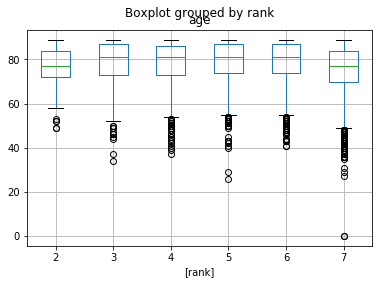

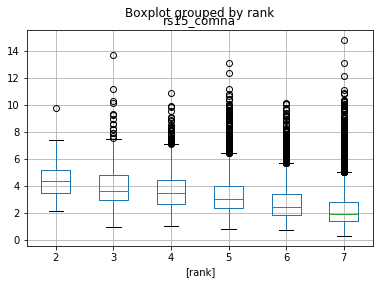

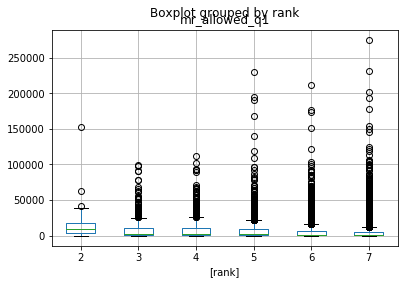

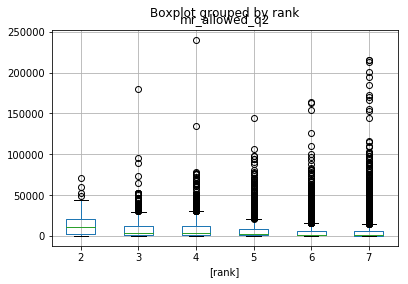

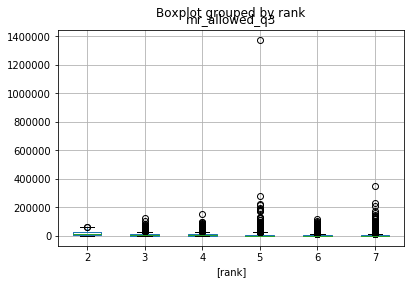

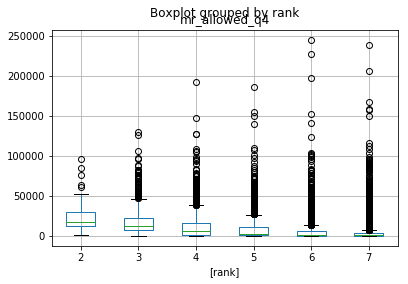

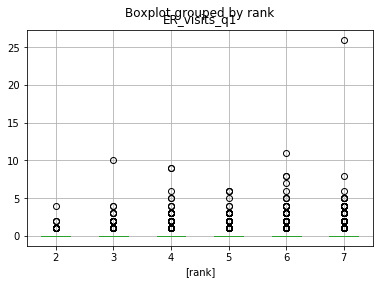

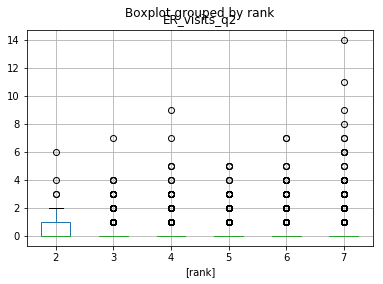

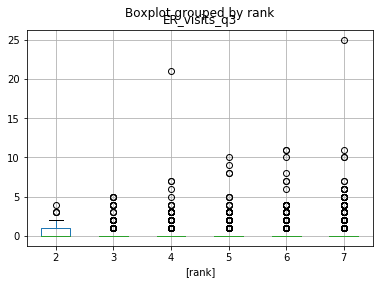

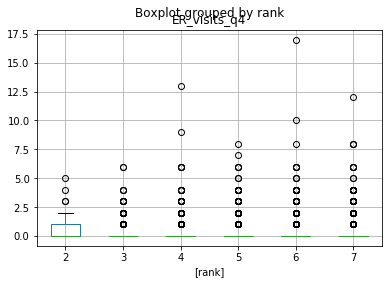

In [59]:
for i in range(0,10):
# for i in range(0,2):
    pd.concat([temppd[['rank']],
               temppd.iloc[:,i]
              ],axis=1).boxplot(by='rank')